In [22]:
# Dependencies
import os
import json
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# reading in JSON data
#JSON data was pulled filtering on Atlanta
with open('../raw_data/atl_weather.json') as f:
  data = json.load(f)

In [24]:
#changing from JSON format into a list

clean_dict_list = []
for x in range(len(data)):
    date = data[x]['dt']
    weather_id = data[x]["weather"][0]["id"]
    weather_group = data[x]["weather"][0]["main"]
    weather = data[x]["weather"][0]["description"]
    temperature = data[x]["main"]["temp"]

    
    weather_dict = {
        "date": date,
        "weather_group": weather_group,
        "weather": weather,
        "temperature": temperature,
    }
    
    clean_dict_list.append(weather_dict)
    


In [25]:
# converting into a DF
df = pd.DataFrame(clean_dict_list)

In [26]:
# date is in UNIX format, convert to datetime
df['date'] = pd.to_datetime(df['date'],unit = 's') 

#datetime is in hours/seconds, use dt.date to remove hours
df['date'] = df['date'].dt.date

# converting report date to match format of weather data
df['date'] = pd.to_datetime(df['date'])

df.tail()


,date,weather_group,weather,temperature
98587,2020-03-31,Clouds,overcast clouds,56.14
98588,2020-03-31,Clouds,overcast clouds,56.97
98589,2020-03-31,Clouds,overcast clouds,56.53
98590,2020-03-31,Rain,light rain,55.89
98591,2020-03-31,Rain,light rain,51.58


In [27]:
# finding unique categories for weather and weather group
print(df['weather'].unique())
print(df['weather_group'].unique())

['sky is clear' 'few clouds' 'scattered clouds' 'overcast clouds'
 'moderate rain' 'light rain' 'mist' 'fog' 'thunderstorm'
 'heavy intensity rain' 'broken clouds' 'thunderstorm with rain' 'haze'
 'light snow' 'light intensity drizzle' 'snow'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'proximity squalls' 'very heavy rain' 'drizzle' 'freezing rain'
 'heavy snow' 'proximity thunderstorm' 'smoke' 'shower rain']
['Clear' 'Clouds' 'Rain' 'Mist' 'Fog' 'Thunderstorm' 'Haze' 'Snow'
 'Drizzle' 'Squall' 'Smoke']


In [28]:
#create a function that goes through each row to see if the weather group is
# rain, thunderstorm or snow. If it is any of these categories then it returns 
# a 1, if it is not then it returns a 0
def weather_variable (row):
    if row['weather_group'] == 'Rain':
        return 1
    if row['weather_group'] == 'Thunderstorm':
        return 1
    if row['weather_group'] == 'Snow':
        return 1
    return 0

# applying the function to go through every row and create a new column called 'rainy'

df['rainy'] = df.apply(lambda row:weather_variable(row),axis = 1)

In [29]:
# grouping by day, finding the mean values of temperature and our rainy number
# if rainy is > 0 this means there was some form of rain that day
# if rainy = 0 this means there was no rain that day

df1 = df.groupby(df.date).mean().reset_index()
df1.head()

,date,temperature,rainy
0,2009-01-01,36.484167,0.000000
1,2009-01-02,41.464167,0.291667
2,2009-01-03,49.450417,0.083333
3,2009-01-04,57.434583,0.291667
4,2009-01-05,60.162500,0.208333


In [30]:
# making the same type of function this time for rainy column
# if rainy > 0 then rain_indicator = 1, if rainy = 0 ,then rain_indicator = 0
# If a day has a 1 then there was rain on that day

def rain_indicator (row):
    if row['rainy'] > 0:
        return 1
    return 0

df1['rain_indicator'] = df1.apply(lambda row:rain_indicator(row),axis = 1)
df1.head()


,date,temperature,rainy,rain_indicator
0,2009-01-01,36.484167,0.000000,0
1,2009-01-02,41.464167,0.291667,1
2,2009-01-03,49.450417,0.083333,1
3,2009-01-04,57.434583,0.291667,1
4,2009-01-05,60.162500,0.208333,1


In [31]:
# converting to a CSV
df1.to_csv('../raw_data/weather_clean.csv')

In [32]:
#importing crime data
file = "../raw_data/all_crime.csv"
crime = pd.read_csv(file)
crime['crime_type'].unique()


array(['LARCENY-NON VEHICLE', 'LARCENY-FROM VEHICLE',
       'ROBBERY-PEDESTRIAN', 'AUTO THEFT', 'AGG ASSAULT',
       'BURGLARY-RESIDENCE', 'BURGLARY-NONRES', 'ROBBERY-COMMERCIAL',
       'ROBBERY-RESIDENCE', 'HOMICIDE', 'MANSLAUGHTER'], dtype=object)

In [33]:
def combining_crimes (row):
    if row['crime_type'] == 'ROBBERY-PEDESTRIAN':
        return 'robbery'
    if row['crime_type'] == 'ROBBERY-RESIDENCE':
        return 'robbery'
    if row['crime_type'] == 'ROBBERY-COMMERCIAL':
        return 'robbery'
    if row['crime_type'] == 'BURGLARY-PEDESTRIAN':
        return 'burglary'
    if row['crime_type'] == 'BURGLARY-NONRES':
        return 'burglary'
    if row['crime_type'] == 'BURGLARY-RESIDENCE':
        return 'burglary'
    if row['crime_type'] == 'LARCENY-NON VEHICLE':
        return 'larceny'
    if row['crime_type'] == 'LARCENY-FROM VEHICLE':
        return 'larceny'
    return row['crime_type']

crime['combo_crime'] = crime.apply(lambda row:combining_crimes(row),axis = 1)
crime['combo_crime'].unique()


array(['larceny', 'robbery', 'AUTO THEFT', 'AGG ASSAULT', 'burglary',
       'HOMICIDE', 'MANSLAUGHTER'], dtype=object)

In [34]:
crimestypes = crime[['combo_crime','index']].groupby('combo_crime').count()
crimestypes

,index
combo_crime,
AGG ASSAULT,25547
AUTO THEFT,47850
HOMICIDE,1003
MANSLAUGHTER,5
burglary,61147
larceny,191547
robbery,21931


In [14]:
# converting report date to match format of weather data
crime['report_date'] = pd.to_datetime(crime['report_date'])
crime['year']=crime['report_date'].dt.year
crime.head()

,index,crime_type,report_date,Beat,Neigborhood,NPU,lat,lon,combo_crime,year
0,0,LARCENY-NON VEHICLE,2009-02-28,301,Adair Park,V,33.72710,-84.41360,larceny,2009
1,1,LARCENY-NON VEHICLE,2009-02-28,509,Downtown,M,33.76158,-84.38496,larceny,2009
2,2,LARCENY-NON VEHICLE,2009-02-28,210,Lenox,B,33.84676,-84.36212,larceny,2009
3,3,LARCENY-NON VEHICLE,2009-02-28,204,Berkeley Park,D,33.80448,-84.41348,larceny,2009
4,4,LARCENY-NON VEHICLE,2009-02-28,609,Edgewood,O,33.75674,-84.34619,larceny,2009


In [15]:
crime1 = crime.rename(columns = {'crime_type':'All_Crime','report_date':'date'})

# joining with weather data
crime_weather = pd.merge(crime1, df1, how = 'inner', on = 'date'  )
crime_weather.head(2)

,index,All_Crime,date,Beat,Neigborhood,NPU,lat,lon,combo_crime,year,temperature,rainy,rain_indicator
0,0,LARCENY-NON VEHICLE,2009-02-28,301,Adair Park,V,33.72710,-84.41360,larceny,2009,55.47125,0.916667,1
1,1,LARCENY-NON VEHICLE,2009-02-28,509,Downtown,M,33.76158,-84.38496,larceny,2009,55.47125,0.916667,1


In [16]:
crime_weather.to_csv('../raw_data/crime_weather.csv')

In [17]:
# creating total crime by date
crime_all = crime[['crime_type','report_date','year']].groupby(['report_date','year']).count().reset_index().rename(columns = {'crime_type':'All_Crime','report_date':'date'})
crime_all
# joining with weather data
crime_all_weather = pd.merge(crime_all, df1, how = 'inner', on = 'date'  )
crime_all_weather.head(1)

,date,year,All_Crime,temperature,rainy,rain_indicator
0,2009-01-01,2009,114,36.484167,0.0,0


In [18]:
crime_by_type = crime[['crime_type','report_date','Beat','year']].groupby(['report_date','year','crime_type']).count().reset_index().rename(columns = {'Beat':'Crime_by_type','report_date':'date'})

# joining with weather data
crime_type_weather = pd.merge(crime_by_type, df1, how = 'inner', on = 'date'  )
crime_all_weather.describe()

,year,All_Crime,temperature,rainy,rain_indicator
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,2012.501027,90.981177,62.099363,0.108872,0.445243
std,2.291829,17.748326,15.077586,0.182503,0.497078
min,2009.000000,21.000000,13.086667,0.000000,0.000000
25%,2011.000000,79.000000,50.423125,0.000000,0.000000
50%,2012.500000,90.000000,64.030000,0.000000,0.000000
75%,2014.750000,103.000000,75.476562,0.166667,1.000000
max,2016.000000,170.000000,90.044167,1.000000,1.000000


In [19]:
crime_all_neighborhood = crime.groupby(['report_date','Neigborhood']).count()

In [20]:
# running regressions
#model is | levels of crime = 1.2*temperature + 9.8*(percent of day that is rainy)

# x = crime_all_weather[['temperature','year']].loc[crime_all_weather['year']==2009].drop(columns = ['year'])
x = crime_all_weather[['temperature','rainy']]
y = crime_all_weather['All_Crime']

model = sm.OLS(y,x).fit()
predictions = model.predict(x)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              All_Crime   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                          2.146e+04
Date:                Sat, 18 Apr 2020   Prob (F-statistic):                        0.00
Time:                        14:22:20   Log-Likelihood:                         -13358.
No. Observations:                2922   AIC:                                  2.672e+04
Df Residuals:                    2920   BIC:                                  2.673e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     1.3838      0.008    177.963      0.000       1.369       1.399
rainy          11.9072      2.338      5.092      0.000       7.322      16.492
==============================================================================
Omnibus:                       66.519   Durbin-Watson:                   0.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.607
Skew:                           0.379   Prob(JB):                     4.65e-16
Kurtosis:                       3.069   Cond. No.                         345.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

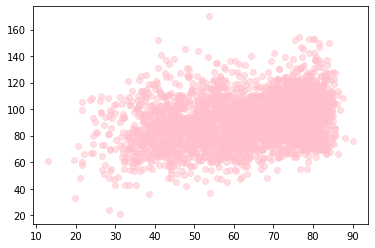

In [21]:
colors = ['pink']
plt.scatter(crime_all_weather['temperature'],crime_all_weather['All_Crime'], c = colors, alpha = .5)

In [ ]:
x = crime_all_weather['date']
y = crime_all_weather['temperature']

plt.plot(x,y)